In [1]:
%matplotlib inline
import re
import nltk
import string
from nltk import word_tokenize
from nltk.corpus import stopwords
from nltk.stem.porter import PorterStemmer
from nltk.stem import WordNetLemmatizer
from nltk import pos_tag
import joblib
from joblib import Parallel, delayed
from tqdm.notebook import tqdm as tqdm
from tqdm.notebook import trange
import contextlib
import numpy as np
import pandas as pd
from scipy.special import digamma
from scipy.stats import norm as normal
from pickle import dump, load
from scipy.sparse import csr_matrix
from gensim.corpora.dictionary import Dictionary
from gensim.models import CoherenceModel, Word2Vec
from gensim.parsing import strip_tags, strip_numeric, strip_multiple_whitespaces, stem_text, strip_punctuation, remove_stopwords
from gensim.parsing import preprocess_string
import os
import sys
import time




/home/iron/Repositories/classes/ml_2_classes/ML2_Exercises/pgm/ex9/.env/lib/python3.8/site-packages/gensim/similarities/__init__.py:15: UserWarning: The gensim.similarities.levenshtein submodule is disabled, because the optional Levenshtein package <https://pypi.org/project/python-Levenshtein/> is unavailable. Install Levenhstein (e.g. `pip install python-Levenshtein`) to suppress this warning.
  warnings.warn(msg)


In [2]:
tqdm.pandas()

@contextlib.contextmanager
def tqdm_joblib(tqdm_object):
    """Context manager to patch joblib to report into tqdm progress bar given as argument"""
    class TqdmBatchCompletionCallback(joblib.parallel.BatchCompletionCallBack):
        def __init__(self, *args, **kwargs):
            super().__init__(*args, **kwargs)

        def __call__(self, *args, **kwargs):
            tqdm_object.update(n=self.batch_size)
            return super().__call__(*args, **kwargs)

    old_batch_callback = joblib.parallel.BatchCompletionCallBack
    joblib.parallel.BatchCompletionCallBack = TqdmBatchCompletionCallback
    try:
        yield tqdm_object
    finally:
        joblib.parallel.BatchCompletionCallBack = old_batch_callback
        tqdm_object.close()  

In [3]:
nltk.download('wordnet')
nltk.download('stopwords')
nltk.download('punkt')

[nltk_data] Downloading package wordnet to /home/iron/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package stopwords to /home/iron/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /home/iron/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

In [4]:
n = 100

seed = 42
data_train = pd.read_csv("data/papers.csv")["paper_text"]
data_train.head()

0    767\n\nSELF-ORGANIZATION OF ASSOCIATIVE DATABA...
1    683\n\nA MEAN FIELD THEORY OF LAYER IV OF VISU...
2    394\n\nSTORING COVARIANCE BY THE ASSOCIATIVE\n...
3    Bayesian Query Construction for Neural\nNetwor...
4    Neural Network Ensembles, Cross\nValidation, a...
Name: paper_text, dtype: object

In [5]:
data_train

0       767\n\nSELF-ORGANIZATION OF ASSOCIATIVE DATABA...
1       683\n\nA MEAN FIELD THEORY OF LAYER IV OF VISU...
2       394\n\nSTORING COVARIANCE BY THE ASSOCIATIVE\n...
3       Bayesian Query Construction for Neural\nNetwor...
4       Neural Network Ensembles, Cross\nValidation, a...
                              ...                        
7236    Single Transistor Learning Synapses\n\nPaul Ha...
7237    Bias, Variance and the Combination of\nLeast S...
7238    A Real Time Clustering CMOS\nNeural Engine\nT....
7239    Learning direction in global motion: two\nclas...
7240    Correlation and Interpolation Networks for\nRe...
Name: paper_text, Length: 7241, dtype: object

In [6]:
data = pd.Series(data_train).sample(n).copy()
data.reset_index(drop=True, inplace=True)
data.head()

0    Self-Adaptable Templates for Feature Coding\n\...
1    The Computation of Stereo Disparity for\nTrans...
2    Error Analysis of Generalized Nystr?m Kernel\n...
3    Semi-Separable Hamiltonian Monte Carlo\nfor In...
4    Learning the Number of Neurons in Deep Network...
Name: paper_text, dtype: object

In [7]:
clean_stem_filters = [strip_tags,
                        strip_numeric,
                        strip_punctuation, 
                        lambda x: x.lower(),
                        lambda s: re.sub(r'\b\w{1,2}\b', ' ', s),
                        strip_multiple_whitespaces,
                        remove_stopwords
                     ]

def text_processing(document):
    lemmatizer = WordNetLemmatizer()
    return [lemmatizer.lemmatize(i) for i in preprocess_string(document, clean_stem_filters)]

In [8]:
def proc_func(data):
    with tqdm_joblib(tqdm(desc="Preprocessing", total=len(data))) as progress_bar:
        data_proc = Parallel(n_jobs=1)(delayed(text_processing)(text) for text in data)
        data_proc = pd.Series(data_proc, index=data.index, name='data')
    return data_proc

In [9]:
data_proc = proc_func(data)
data_proc.head()

Preprocessing:   0%|          | 0/100 [00:00<?, ?it/s]

0    [self, adaptable, template, feature, coding, x...
1    [computation, stereo, disparity, transparent, ...
2    [error, analysis, generalized, nystr, kernel, ...
3    [semi, separable, hamiltonian, monte, carlo, i...
4    [learning, number, neuron, deep, network, jose...
Name: data, dtype: object

In [10]:
def encode2(text, word_dict):
    return np.asarray(word_dict.doc2idx(text))

In [11]:
word_dict = Dictionary(data_proc)
data_enc = data_proc.progress_apply(lambda x: encode2(x, word_dict))

  0%|          | 0/100 [00:00<?, ?it/s]

In [12]:
D = len(data_enc)
Ns = data_enc.apply(lambda x: len(x)).to_numpy().astype(int)
N = Ns.sum()
V = len(word_dict)
Gs = [None] * D

In [13]:
print(D, Ns, N, V, len(Gs))

100 [2159 1039 2113 2679 2825 2118 2585 2260 2429  990 2789 1483 2222 1717
 2304 2845 2604 1309 1126 2664 2262 1090  978 2115  875 2978 2854 1310
 1665 1910 1932 1778 2633 1797 1440 1480 2855 2504 1993 1385 2299 2219
 2851 1031 2795 2525 2347 2602 2769 1775 2314 2818 1519 2519 2348 2482
 1112 1702 2493    0  711 2980 3456 2720  889 2841 2388 1559 1137 2439
 1701 1190 3057 2201 1966 1197 1298 2113 1310 1594 1442 1351  761 1545
 2188 2431 2232 1953 1073 1857 2027 2615 1745 1453 1440 1285 1688 2564
 3445 2498] 198954 13861 100


In [14]:
# https://people.eecs.berkeley.edu/~jordan/papers/hdp.pdf

In [15]:
class DP0:
    def __init__(self, a, H_var):
        self.a = a
        self.H_var = H_var
        self.H = normal(0, H_var)
        self.K = 0 # Dishes
        self.phi_k = [] # Dish ID
        self.t_k = [] # Number of tables serving dish K

    def prior_sample(self):
        denom = 1./(sum(self.t_k)+self.a)
        alphas = np.asarray(self.t_k + [self.a]) * denom
        probs = np.random.dirichlet(alphas)
        k = np.random.choice(range(self.K+1), p=probs)
        if k+1 > self.K:
            self.K += 1
            self.phi_k.append(self.H.rvs())

        return self.phi_k[k], k
    
    def increase_dish_count(self, dish):
        if len(self.t_k) <= dish:
            self.t_k += [0] * ((dish+1) - len(self.t_k))
        self.t_k[dish] += 1

    def decrease_dish_count(self, dish):
        if len(self.t_k) > dish:
            self.t_k[dish] -= 1

class DP1:
    def __init__(self, a, DP, words):
        self.a = a
        self.G = DP
        self.t = 0 # Num tables
        self.psi_t = [] # Dish served at table t
        self.psi_t_dist = [] # Distribution of psi_t
        self.m = [] # Num of tables serving k
        self.n_tk = [] # Num of customers at table t eating k
        self.k_t = [] # Index of phi_k corresponding to psi_t
        self.theta_i = [None] * len(words) # Table index where customer i sits
        self.words = words
        self.embeddings = np.zeros(len(words))
        
        self._init_sample()
        
    def _init_sample(self):
        for i in range(len(self.words)):
            denom = 1./(i+self.a)
            if len(self.n_tk) == 0:
                alphas = [self.a * denom]
            else:
                n_sitted = [np.sum(t) for t in self.n_tk]
                alphas = np.asarray(n_sitted + [self.a]) * denom
            probs = np.random.dirichlet(alphas)
            t = np.random.choice(range(self.t+1), p=probs)
            if t+1 > self.t:
                self.t += 1
                phi_k, k = self.G.prior_sample()
                self.psi_t.append(phi_k)
                self.psi_t_dist.append(normal(self.psi_t[-1], self.G.H_var))
                self.k_t.append(k)
                if len(self.m) <= k:
                    self.m.append(1)
                else:
                    self.m[k] += 1
                if len(self.n_tk) <= self.t:
                    self.n_tk.append([])
                
                self.G.increase_dish_count(k)

            if len(self.n_tk[t]) <= k:
                    self.n_tk[t] += [0] * ((k+1)-len(self.n_tk[t]))
                    
            self.n_tk[t][k] += 1
            self.theta_i[i] = t
            self.embeddings[i] = self.psi_t_dist[self.theta_i[i]].rvs()


In [16]:
H_var = 1
a = 5
a, H_var

(5, 1)

In [17]:
dp = DP0(a, H_var)
gjs = []

In [18]:
for d in tqdm(data_enc[:5]):
    gjs.append(DP1(5, dp, list(d)))

  0%|          | 0/5 [00:00<?, ?it/s]

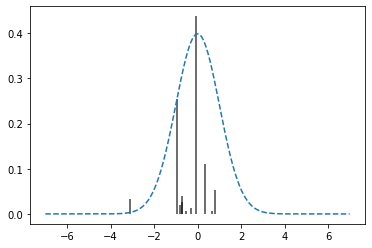

In [19]:
import matplotlib.pyplot as plt

x = np.arange(-7, 7, 0.01)
y = dp.H.pdf(x)

plt.plot(x, y, linestyle='--')

plt.vlines(dp.phi_k, ymin=0, ymax=np.array(dp.t_k)/sum(dp.t_k), color='k', alpha=0.75)

In [20]:
gjs[0].embeddings

array([-1.3791663 ,  1.0277201 , -2.80220029, ...,  0.30816899,
       -1.4015299 , -0.2302015 ])

In [21]:
gjs[0].t

23